# Fraude en Transacciones Financieras

[![Banner.png](https://i.postimg.cc/C1t2SCwf/Banner.png)](https://postimg.cc/FdypxLd9)

## Introducción

Este notebook se enfoca en la extracción, transformación y carga (ETL) de datos de transacciones financieras para prepararlos para el análisis posterior. 

**Las tareas principales incluyen:**

Extracción: Obtener datos de una fuente externa, como una base de datos o API.
Transformación: Limpiar, formatear y transformar los datos para que sean consistentes y adecuados para el análisis.
Carga: Almacenar los datos transformados en un formato adecuado para su posterior análisis, como una base de datos o un archivo CSV.
Objetivos:

Preparar un conjunto de datos limpio y consistente para el análisis de fraude en transacciones financieras.
Garantizar la calidad y confiabilidad de los datos para obtener resultados precisos en el análisis.
Facilitar el acceso y la manipulación de los datos para futuros análisis.

### Instalaremos paquetes y librerías necesarias para descargar, trabajar los DataSets para cumplir con nuestro MVP descrito en nuestro README.md

In [1]:
# Instalo manualmente algunas bibliotecas
%pip install pip
%pip install numpy
%pip install pandas
%pip install --upgrade requests
%pip install requests
%pip install lxml
%pip install cssselect
%pip install urllib3
%pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importo librerías y paquetes necesarios
import numpy as np
import pandas as pd
import zipfile
import os
import json
import requests
import ssl
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import urllib3

# Importo funciones necesarias
from pandas import to_datetime
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.exceptions import InsecureRequestWarning
from requests.packages.urllib3.poolmanager import PoolManager
from tqdm import tqdm

### Trato advertencias

In [3]:
# Deshabilito advertencias de solicitudes inseguras.
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

### Llamaré a los archivos con los que trabajaremos.

In [4]:
# Rutas a los archivos ZIP y el endpoint de la API
credit_card_zip_path = r"C:\\Users\Esteban García\\OneDrive\\Escritorio\\LABs\\Datasets para Trabajar NoCountry\\DataFrames\\Credit Card Transactions Fraud Detection Dataset.zip"
ecommerce_zip_path = r"C:\\Users\\Esteban García\\OneDrive\\Escritorio\\LABs\\Datasets para Trabajar NoCountry\\DataFrames\\Fraudulent E-commerce Transactions.zip"

# Endpoint de la API del BCRA (ajustar según la documentación)
bcra_api_url = "https://api.bcra.gob.ar/estadisticas/v2.0/PrincipalesVariables"

### Establezco la ruta donde guardaré los df y *.csv

In [5]:
output_dir = r"C:\\Users\\Esteban García\\OneDrive\\Escritorio\\LABs\\Datasets para Trabajar NoCountry\\DataFrames\\DF Procesados"

### Defino la función para explorar los documentos

In [6]:
# Función para explorar y analizar los archivos *.zip

def list_files_in_zip(zip_path):
    """Listo los archivos dentro de un archivo ZIP."""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        return zip_ref.namelist()

def extract_and_read_zip(zip_path, file_name):
    """Extraigo los archivos ZIP y leo los datasets."""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("temp_dataset")
        file_path = os.path.join("temp_dataset", file_name)
        return pd.read_csv(file_path)

### Verifico que la extracción de los archivos fue existosa.

In [7]:
# Verifico los nombres de los archivos dentro de los ZIPs
credit_card_files = list_files_in_zip(credit_card_zip_path)
ecommerce_files = list_files_in_zip(ecommerce_zip_path)

# Verifico la lectura correcta de los archivos
credit_card_file_name = next((file for file in credit_card_files if file.endswith('.csv')), None)
ecommerce_file_name = next((file for file in ecommerce_files if file.endswith('.csv')), None)

if credit_card_file_name:
    credit_card_df = extract_and_read_zip(credit_card_zip_path, credit_card_file_name)
else:
    print("No se encontró un archivo CSV en el ZIP de tarjetas de crédito.")

if ecommerce_file_name:
    ecommerce_df = extract_and_read_zip(ecommerce_zip_path, ecommerce_file_name)
else:
    print("No se encontró un archivo CSV en el ZIP de comercio electrónico.")

### Consulto la APIs del BCRA

In [8]:
# Determino la URL base de la API
base_url = "https://api.bcra.gob.ar/estadisticas/v2.0/"

# Establezco el endpoint para obtener principales variables
variables_url = base_url + "principalesvariables"

# Solicito los datos de principales variables
response = requests.get(variables_url, verify=False)
if response.status_code == 200:
    variables = response.json()['results']
else:
    print("Error al obtener principales variables:", response.status_code)

# Creo un DataFrame con las principales variables
bcra_df = pd.DataFrame(variables)

# Muestro las primeras filas del DataFrame
print(bcra_df.head())

# Guardar el DataFrame en un archivo CSV
output_dir = r"C:\\Users\\Esteban García\\OneDrive\\Escritorio\\LABs\\Datasets para Trabajar NoCountry\\DataFrames\\DF Procesados"
bcra_df.to_csv(output_dir + "principales_variables.csv", index=False)

# Función para obtener datos de una variable específica
def obtener_datos_variable(id_variable, desde, hasta):
    datos_url = f"{base_url}datosvariable/{id_variable}/{desde}/{hasta}"
    response = requests.get(datos_url, verify=False)
    if response.status_code == 200:
        return response.json()['results']
    else:
        print("Error al obtener datos de la variable:", response.status_code)
        return []

# Establezco el rango de fechas para el año 2024
id_variable = 1  # ID de la variable a consultar
desde = "2024-01-01"  # Fecha de inicio del rango
hasta = "2024-12-31"  # Fecha de fin del rango

datos_variable = obtener_datos_variable(id_variable, desde, hasta)

# Creo el DataFrame con los datos de la variable
bcra_df = pd.DataFrame(datos_variable)

# Mostrar las primeras filas del DataFrame de datos de la variable
print(bcra_df.head())

# Guardar el DataFrame en un archivo CSV
bcra_df.to_csv(output_dir + "datos_variable.csv", index=False)

   idVariable  cdSerie                                        descripcion  \
0           1      246  Reservas Internacionales del BCRA (en millones...   
1           4     7927  Tipo de Cambio Minorista ($ por USD) Comunicac...   
2           5      272  Tipo de Cambio Mayorista ($ por USD) Comunicac...   
3           6     7935             Tasa de Política Monetaria (en % n.a.)   
4           7     1222     BADLAR en pesos de bancos privados (en % n.a.)   

        fecha       valor  
0  2024-07-19  27565.0000  
1  2024-07-23    964.3900  
2  2024-07-23    927.3300  
3  2024-07-23     40.0000  
4  2024-07-22     38.6875  
   idVariable       fecha    valor
0           1  2024-01-02  23470.0
1           1  2024-01-03  23677.0
2           1  2024-01-04  23835.0
3           1  2024-01-05  24119.0
4           1  2024-01-08  23233.0


### Visualizo los df para ver su contenido para tener un primer acercamiento al contenido, visualizarlo y entender los pasos a seguir.

Al haber una reducción de personal a última hora, elegimos trabajar con el DataFrame llamado ecommerce_df

### Importamos el dataset

In [9]:
ecommerce_df

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472947,c8604004-2f4c-42ce-a1c4-cd2bebca79bb,f8a534ad-0458-465e-a85b-3ad2cdf391bc,208.48,2024-01-12 23:39:55,PayPal,health & beauty,2,29,North Laurafort,desktop,27.245.104.92,USNV Griffin\nFPO AA 52700,USNV Griffin\nFPO AA 52700,0,149,23
1472948,fff0df19-fd4a-42a5-bc42-64bb7b02edb0,f2ef2239-d9b9-40d0-9993-4b8f305d5a7b,231.57,2024-03-27 04:31:45,credit card,clothing,2,32,Burnsville,tablet,203.54.50.163,"478 John Square Apt. 235\nMillerhaven, GA 68797","478 John Square Apt. 235\nMillerhaven, GA 68797",0,132,4
1472949,9e79012f-e00b-47d1-8700-0c302db20d3e,fa5b9a25-9606-478a-8abe-ef20bbb3980f,101.80,2024-01-31 23:51:42,bank transfer,electronics,4,36,Garciafort,mobile,51.241.30.149,"351 Frazier Radial Apt. 989\nPort Charles, OH ...","182 House Island Suite 198\nEast Scott, FM 84301",0,98,23
1472950,917066b1-4dfb-4472-b3f0-292663c45d21,04524272-e14f-460b-bc70-5316bd28463d,61.80,2024-01-12 16:21:32,bank transfer,electronics,5,34,Lake Josephberg,desktop,210.67.203.4,"27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...","27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...",0,191,16


### Análisis exploratorio de fraudes en e-commerce_df

Visualizamos las columnas

In [10]:
print(ecommerce_df.columns)

Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date', 'Payment Method', 'Product Category', 'Quantity',
       'Customer Age', 'Customer Location', 'Device Used', 'IP Address',
       'Shipping Address', 'Billing Address', 'Is Fraudulent',
       'Account Age Days', 'Transaction Hour'],
      dtype='object')


### Verificamos los tipos de datos.

In [11]:
"""lo que pretendemos realizar es identificar las
variables numéricas, categóricas y de texto"""
# Verifique los tipos de datos en su DataFrame (opcional)
print(ecommerce_df.dtypes)  # Data Analyst: Comentar esta línea si ya conoces los tipos

Transaction ID         object
Customer ID            object
Transaction Amount    float64
Transaction Date       object
Payment Method         object
Product Category       object
Quantity                int64
Customer Age            int64
Customer Location      object
Device Used            object
IP Address             object
Shipping Address       object
Billing Address        object
Is Fraudulent           int64
Account Age Days        int64
Transaction Hour        int64
dtype: object


### Procederemos a continuar con un análisis inicial y exploratorio para conocer un poco más de los datos contenidos.

Realizamos una evaluación de valores nulos.

In [12]:
"""procederemos a normalizar el contenido de cada fila,
lo que pretendemos realizar con este script,
analizar la calidad de los datos"""

# Verifico valores nulos en las columnas
valores_nulos = ecommerce_df.isna().sum()
print("Valores nulos por columna:")
print(valores_nulos)

Valores nulos por columna:
Transaction ID        0
Customer ID           0
Transaction Amount    0
Transaction Date      0
Payment Method        0
Product Category      0
Quantity              0
Customer Age          0
Customer Location     0
Device Used           0
IP Address            0
Shipping Address      0
Billing Address       0
Is Fraudulent         0
Account Age Days      0
Transaction Hour      0
dtype: int64


### Procederemos a visualizar el contenido de las filas de cada columna.

In [13]:
"""pretendemos tener una idea general del contenido y formato de los datos"""
print(ecommerce_df.head())

                         Transaction ID                           Customer ID  \
0  15d2e414-8735-46fc-9e02-80b472b2580f  d1b87f62-51b2-493b-ad6a-77e0fe13e785   
1  0bfee1a0-6d5e-40da-a446-d04e73b1b177  37de64d5-e901-4a56-9ea0-af0c24c069cf   
2  e588eef4-b754-468e-9d90-d0e0abfc1af0  1bac88d6-4b22-409a-a06b-425119c57225   
3  4de46e52-60c3-49d9-be39-636681009789  2357c76e-9253-4ceb-b44e-ef4b71cb7d4d   
4  074a76de-fe2d-443e-a00c-f044cdb68e21  45071bc5-9588-43ea-8093-023caec8ea1c   

   Transaction Amount     Transaction Date Payment Method Product Category  \
0               58.09  2024-02-20 05:58:41  bank transfer      electronics   
1              389.96  2024-02-25 08:09:45     debit card      electronics   
2              134.19  2024-03-18 03:42:55         PayPal    home & garden   
3              226.17  2024-03-16 20:41:31  bank transfer         clothing   
4              121.53  2024-01-15 05:08:17  bank transfer         clothing   

   Quantity  Customer Age Customer Location 

In [14]:
"""con esta normalización pretendemos mejorar la consistencia y facilitar su análisis"""
# Normalización del contenido de las columnas con texto
columns_with_text = ['Payment Method', 'Product Category', 'Customer Location', 'Device Used', 'Shipping Address', 'Billing Address']

for col in columns_with_text:
    ecommerce_df[col] = ecommerce_df[col].str.title()

### En el próximo paso, procederemos a realizar una manipulación de la columna 'Transaction Date' y 'Transaction Hour'

In [15]:
"""analizando las columnas, veo 'Transaction .....', el cual debo modificar, 
creando dos columnas una que contenga el día y otra que contenga la hora, 
una vez creadas, cambiaré a los datos contenidos 
a tipo datetime y después elimino la columna original"""

# Análisis de columnas
for col in tqdm(ecommerce_df.columns):
    print(f"Columna: {col}, Tipo de dato: {ecommerce_df[col].dtype}")

# Modificación de la columna "Transaction Date"
print("\nModificando columna 'Transaction Date'...")
ecommerce_df[['Transaction Day', 'Transaction Hour']] = ecommerce_df['Transaction Date'].str.split(' ', expand=True)

# Formateo de las nuevas columnas
ecommerce_df['Transaction Day'] = pd.to_datetime(ecommerce_df['Transaction Day'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')
ecommerce_df['Transaction Hour'] = pd.to_datetime(ecommerce_df['Transaction Hour'], format='%H:%M:%S').dt.strftime('%H:%M:%S')

# Eliminación de la columna original "Transaction Date"
if 'Transaction Date' in ecommerce_df.columns:
    ecommerce_df.drop(columns=['Transaction Date'], inplace=True)

# Visualización del resultado
print("\nResultado:")
print(ecommerce_df.head())


100%|██████████| 16/16 [00:00<00:00, 2510.24it/s]


Columna: Transaction ID, Tipo de dato: object
Columna: Customer ID, Tipo de dato: object
Columna: Transaction Amount, Tipo de dato: float64
Columna: Transaction Date, Tipo de dato: object
Columna: Payment Method, Tipo de dato: object
Columna: Product Category, Tipo de dato: object
Columna: Quantity, Tipo de dato: int64
Columna: Customer Age, Tipo de dato: int64
Columna: Customer Location, Tipo de dato: object
Columna: Device Used, Tipo de dato: object
Columna: IP Address, Tipo de dato: object
Columna: Shipping Address, Tipo de dato: object
Columna: Billing Address, Tipo de dato: object
Columna: Is Fraudulent, Tipo de dato: int64
Columna: Account Age Days, Tipo de dato: int64
Columna: Transaction Hour, Tipo de dato: int64

Modificando columna 'Transaction Date'...

Resultado:
                         Transaction ID                           Customer ID  \
0  15d2e414-8735-46fc-9e02-80b472b2580f  d1b87f62-51b2-493b-ad6a-77e0fe13e785   
1  0bfee1a0-6d5e-40da-a446-d04e73b1b177  37de64d5-e9

In [16]:
"""
reoganizo las columnas del dataset con la finalidad de darle 
un orden específico y más entendible
"""
# Reorganizo las columnas
column_order = [
    'Transaction ID', 'Customer ID', 'Transaction Amount', 'Transaction Day', 'Transaction Hour',
    'Payment Method', 'Product Category', 'Quantity', 'Customer Age', 'Customer Location',
    'Device Used', 'IP Address', 'Shipping Address', 'Billing Address', 'Is Fraudulent',
    'Account Age Days'
]
ecommerce_df = ecommerce_df[column_order]

# Elimino la columna original "Transaction Date"
if 'Transaction Date' in ecommerce_df.columns:
    ecommerce_df.drop(columns=['Transaction Date'], inplace=True)

### Visualizamos algunas columnas para encontrar anomalías.

Analizando columnas...


100%|██████████| 16/16 [00:00<00:00, 5336.69it/s]

Columna: Transaction ID, Tipo de dato: object
Columna: Customer ID, Tipo de dato: object
Columna: Transaction Amount, Tipo de dato: float64
Columna: Transaction Day, Tipo de dato: object
Columna: Transaction Hour, Tipo de dato: object
Columna: Payment Method, Tipo de dato: object
Columna: Product Category, Tipo de dato: object
Columna: Quantity, Tipo de dato: int64
Columna: Customer Age, Tipo de dato: int64
Columna: Customer Location, Tipo de dato: object
Columna: Device Used, Tipo de dato: object
Columna: IP Address, Tipo de dato: object
Columna: Shipping Address, Tipo de dato: object
Columna: Billing Address, Tipo de dato: object
Columna: Is Fraudulent, Tipo de dato: int64
Columna: Account Age Days, Tipo de dato: int64



Detectando valores atípicos...


 20%|██        | 1/5 [02:33<10:13, 153.41s/it]

Columna: Transaction Amount, Cantidad de valores atípicos: 79180


 40%|████      | 2/5 [05:06<07:39, 153.11s/it]

Columna: Quantity, Cantidad de valores atípicos: 0


 60%|██████    | 3/5 [07:19<04:47, 143.89s/it]

Columna: Customer Age, Cantidad de valores atípicos: 13746


 80%|████████  | 4/5 [09:32<02:19, 139.65s/it]

Columna: Is Fraudulent, Cantidad de valores atípicos: 73838


100%|██████████| 5/5 [11:59<00:00, 143.93s/it]

Columna: Account Age Days, Cantidad de valores atípicos: 0

Creando gráficos de boxplot...


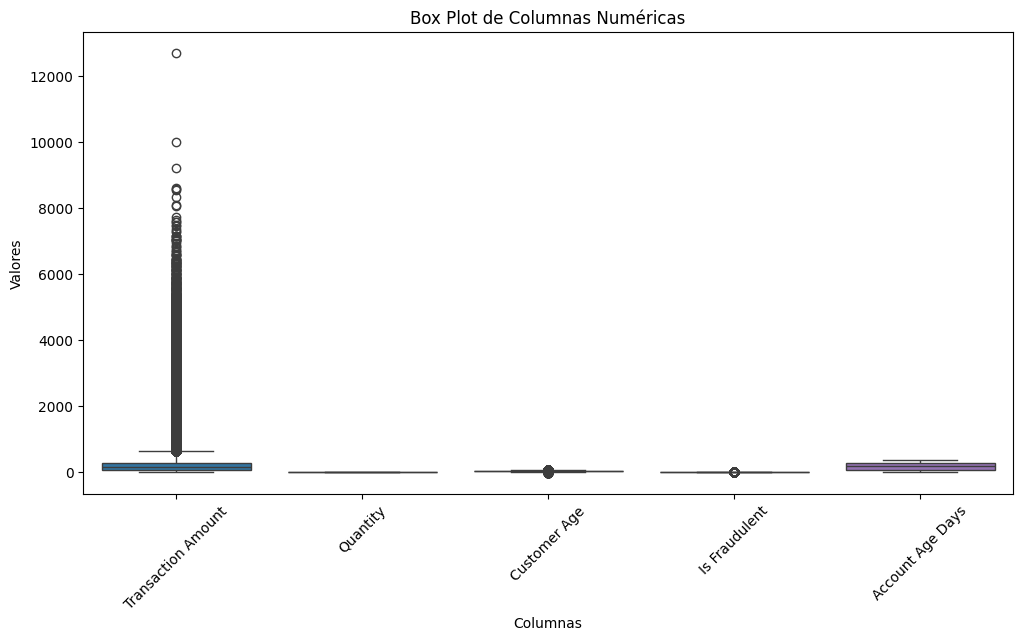

In [17]:
"""la finalidad de seleccionar las columnas y visualizar su información para 
detectar valores atípicos utilizamos box plots para visualizar la 
distribución de los datos e identificar posibles outliers
"""

# Análisis de columnas
print("Analizando columnas...")
for col in tqdm(ecommerce_df.columns):
    print(f"Columna: {col}, Tipo de dato: {ecommerce_df[col].dtype}")

# Selección de columnas numéricas
numeric_columns = ecommerce_df.select_dtypes(include=['float64', 'int64'])

# Detección de valores atípicos con tqdm
print("\nDetectando valores atípicos...")
for col in tqdm(numeric_columns.columns):
    Q1 = numeric_columns[col].quantile(0.25)
    Q3 = numeric_columns[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR

    outliers_count = 0
    for index, row in ecommerce_df.iterrows():
        if row[col] < lower_threshold or row[col] > upper_threshold:
            outliers_count += 1

    print(f"Columna: {col}, Cantidad de valores atípicos: {outliers_count}")

"""
los box splot permitirán visualizar la distribución de datos:
la mediana, los cuartiles y valores atípicos
"""

# Creación de gráficos de boxplot
print("\nCreando gráficos de boxplot...")
plt.figure(figsize=(12, 6))
sns.boxplot(data=numeric_columns)
plt.xticks(rotation=45)
plt.title("Box Plot de Columnas Numéricas")
plt.xlabel("Columnas")
plt.ylabel("Valores")
plt.show()


In [19]:
"""
en la columna que estamos analizando, trataremos de identificar 
posibles valores atípicos utilizando las estadísticas descriptivas
de la columna para obtener la información sobre la distribución de los datos
"""
# Verifico valores atípicos (outliers) en 'Customer Age'
print("\nEstadísticas de 'Customer Age':")
print(ecommerce_df['Customer Age'].describe())



Estadísticas de 'Customer Age':
count    1.472952e+06
mean     3.451208e+01
std      1.000313e+01
min     -1.600000e+01
25%      2.800000e+01
50%      3.500000e+01
75%      4.100000e+01
max      8.600000e+01
Name: Customer Age, dtype: float64


Al analizar la salida de 'Customer Age' con describe, se ha identificado un valor atípico en la columna 'Customer Age'. Este outlier debe ser tratado antes de realizar análisis posteriores para obtener resultados más precisos y confiables.

### Vamos a visualizar los outliers saber ¿qué porcentaje representan? y eliminarlos para nuestro posterior trabajo de EDA.

In [20]:
"""
utilizaré cuartiles y el IQR o rango intercuatílico para definir 
los límites superior e inferior, la finalidad de dicho trabajo,
es que los valores fuera de esos rangos serán considerados outliers
"""
# Obtengo el IQR
iqr = ecommerce_df['Customer Age'].quantile(0.75) - ecommerce_df['Customer Age'].quantile(0.25)

# Defino el límite superior e inferior
upper_bound = ecommerce_df['Customer Age'].quantile(0.75) + 1.5 * iqr
lower_bound = ecommerce_df['Customer Age'].quantile(0.25) - 1.5 * iqr

# Identifico outliers
outliers = ecommerce_df[(ecommerce_df['Customer Age'] > upper_bound) | (ecommerce_df['Customer Age'] < lower_bound)]


### Visualizo para entender dicha información

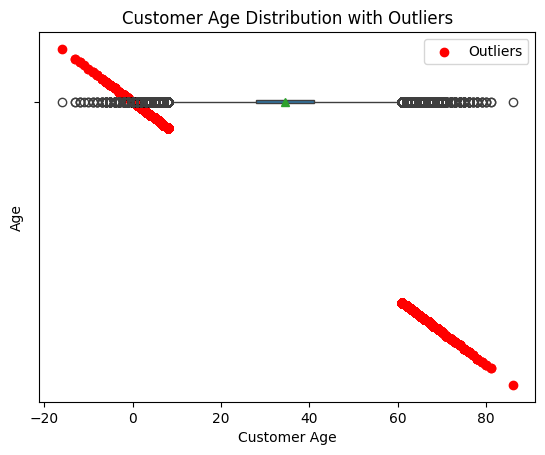

In [21]:
sns.boxplot(
    x = "Customer Age",
    showmeans=True,  # Show mean as a diamond
    data=ecommerce_df
)

# Highlight outliers with red points
plt.scatter(
    outliers['Customer Age'],  # x-coordinates of outliers
    outliers['Customer Age'],  # y-coordinates of outliers (same as x for points)
    color='red',
    label='Outliers'
)

# Add labels and title
plt.xlabel('Customer Age')
plt.ylabel('Age')
plt.title('Customer Age Distribution with Outliers')

# Show legend
plt.legend()

# Display the plot
plt.show()


### Determinaré el porcentaje de datos negativos.

In [22]:
"""
identificadas las edades negativas, (no existen edades negativas en la realidad)
se estima que es un error en la carga de los datos,
calculamos el porcentaje que representan sobre el total del df para posteriormente eliminarlos
"""
# Identifico datos negativos en la columna edad
negative_ages = ecommerce_df[ecommerce_df['Customer Age'] < 0]

# Calculo el total
total_records = len(ecommerce_df)

# Calculo los negativos
negative_age_count = len(negative_ages)

# Calculo el porcentaje que representa sobre el total de la columna
negative_age_percentage = (negative_age_count / total_records) * 100

# Visualizo
print(f"Porcentaje de edades negativas: {negative_age_percentage:.2f}%")


Porcentaje de edades negativas: 0.02%


El ser un porcentaje muy bajo, no afectará la eliminación de los mismos.

In [23]:
# Procederé a eliminar los outliers o edades negativas ya que las mismas no existen.
ecommerce_df = ecommerce_df[ecommerce_df['Customer Age'] >= 0]

"""aquí eliminamos los outliers y creamos un nuevo
dataset que solo incluyan registros válidos
cuydas edades sean mayores o iguales a cero"""

# Verifico la cantidad de registros restantes
print("Cantidad de registros restantes:", len(ecommerce_df))

Cantidad de registros restantes: 1472694


### Ahora procedo a graficar un histograma.

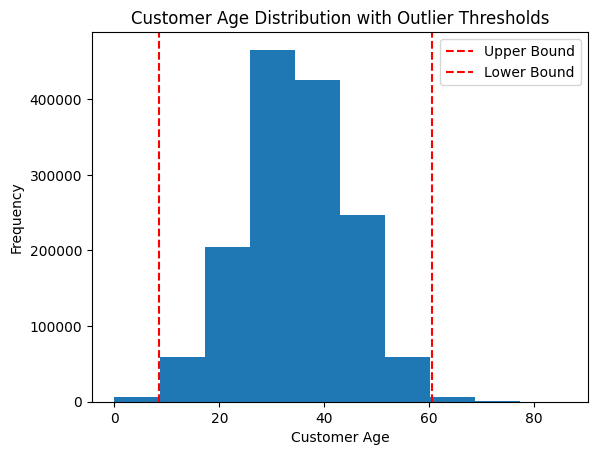

In [24]:
"""
la finalidad de este bloque es visualizar la distribución de las edades
después de haber eliminado los outliers, para ello utilizaremos un
histograma para mostrar dicha frecuencia de los valores de edad
agregando líneas rojas para indicar los límites superior e inferior
"""
plt.hist(ecommerce_df['Customer Age'])

# Plot threshold lines for upper and lower bounds
plt.axvline(x=upper_bound, color='red', linestyle='--', label='Upper Bound')
plt.axvline(x=lower_bound, color='red', linestyle='--', label='Lower Bound')

# Add labels and title
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.title('Customer Age Distribution with Outlier Thresholds')

# Add legend
plt.legend()

# Display the plot
plt.show()


In [25]:
ecommerce_df

,Transaction ID,Customer ID,Transaction Amount,Transaction Day,Transaction Hour,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,20-02-2024,05:58:41,Bank Transfer,Electronics,1,17,Amandaborough,Tablet,212.195.49.198,Unit 8934 Box 0058\nDpo Aa 05437,Unit 8934 Box 0058\nDpo Aa 05437,0,30
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,25-02-2024,08:09:45,Debit Card,Electronics,2,40,East Timothy,Desktop,208.106.249.121,"634 May Keys\nPort Cherylview, Nv 75063","634 May Keys\nPort Cherylview, Nv 75063",0,72
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,18-03-2024,03:42:55,Paypal,Home & Garden,2,22,Davismouth,Tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, Il 15564","16282 Dana Falls Suite 790\nRothhaven, Il 15564",0,63
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,16-03-2024,20:41:31,Bank Transfer,Clothing,5,31,Lynnberg,Desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, Ut 84798","828 Strong Loaf Apt. 646\nNew Joshua, Ut 84798",0,124
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,15-01-2024,05:08:17,Bank Transfer,Clothing,2,51,South Nicole,Tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472947,c8604004-2f4c-42ce-a1c4-cd2bebca79bb,f8a534ad-0458-465e-a85b-3ad2cdf391bc,208.48,12-01-2024,23:39:55,Paypal,Health & Beauty,2,29,North Laurafort,Desktop,27.245.104.92,Usnv Griffin\nFpo Aa 52700,Usnv Griffin\nFpo Aa 52700,0,149
1472948,fff0df19-fd4a-42a5-bc42-64bb7b02edb0,f2ef2239-d9b9-40d0-9993-4b8f305d5a7b,231.57,27-03-2024,04:31:45,Credit Card,Clothing,2,32,Burnsville,Tablet,203.54.50.163,"478 John Square Apt. 235\nMillerhaven, Ga 68797","478 John Square Apt. 235\nMillerhaven, Ga 68797",0,132
1472949,9e79012f-e00b-47d1-8700-0c302db20d3e,fa5b9a25-9606-478a-8abe-ef20bbb3980f,101.80,31-01-2024,23:51:42,Bank Transfer,Electronics,4,36,Garciafort,Mobile,51.241.30.149,"351 Frazier Radial Apt. 989\nPort Charles, Oh ...","182 House Island Suite 198\nEast Scott, Fm 84301",0,98
1472950,917066b1-4dfb-4472-b3f0-292663c45d21,04524272-e14f-460b-bc70-5316bd28463d,61.80,12-01-2024,16:21:32,Bank Transfer,Electronics,5,34,Lake Josephberg,Desktop,210.67.203.4,"27307 Gonzalez Shore Suite 661\nPort Lynn, Wv ...","27307 Gonzalez Shore Suite 661\nPort Lynn, Wv ...",0,191


### Procederé a realizar una normalización del contenido.

In [26]:
"""
verifico si los nombres de las columnas del df coinciden con su contenido esperado, 
recorreremos las columnas y compararemos cada nombre con su versión normalizada
.... lo que haremos es reemplazar espacios por guiones bajos y convirtiendo a minúsculas
.... Si se encuentra alguna discrepancia, imprimiremos un mensaje de advertencia.
"""
# Verifico si los nombres de las columnas coinciden con su contenido
nombres_columnas = ecommerce_df.columns
for columna in nombres_columnas:
    contenido_esperado = columna.replace(" ", "_").lower()  
    if contenido_esperado not in ecommerce_df.columns:
        print(f"El nombre de la columna '{columna}' no coincide con su contenido esperado.")

El nombre de la columna 'Transaction ID' no coincide con su contenido esperado.
El nombre de la columna 'Customer ID' no coincide con su contenido esperado.
El nombre de la columna 'Transaction Amount' no coincide con su contenido esperado.
El nombre de la columna 'Transaction Day' no coincide con su contenido esperado.
El nombre de la columna 'Transaction Hour' no coincide con su contenido esperado.
El nombre de la columna 'Payment Method' no coincide con su contenido esperado.
El nombre de la columna 'Product Category' no coincide con su contenido esperado.
El nombre de la columna 'Quantity' no coincide con su contenido esperado.
El nombre de la columna 'Customer Age' no coincide con su contenido esperado.
El nombre de la columna 'Customer Location' no coincide con su contenido esperado.
El nombre de la columna 'Device Used' no coincide con su contenido esperado.
El nombre de la columna 'IP Address' no coincide con su contenido esperado.
El nombre de la columna 'Shipping Address' no 

In [27]:
"""
buscamos con esta normalización nombres más consistentes, 
legibles y fáciles de manejar en el código
"""
def normalize_column_name(column_name):
    """
    Función para normalizar el nombre de una columna.

    Args:
        column_name (str): El nombre original de la columna.

    Returns:
        str: El nombre normalizado de la columna.
    """
    # Elimino espacios en blanco
    normalized_name = column_name.replace(" ", "_")

    # Convierto a minúsculas
    normalized_name = normalized_name.lower()

    return normalized_name


### Imprimiré la información sobre cada columna original, la idea es visualizar el contenido esperado normalizado y dos ejemplos para verificar la correcta normalización.

In [28]:
# Obtengo los nombres de las columnas
column_names = ecommerce_df.columns

# Recorro cada columna
for column_name in column_names:
    # Obtengo el contenido esperado
    expected_content = normalize_column_name(column_name)

    # Muestro la información
    print(f"\nColumna: {column_name}")
    print(f"Contenido esperado: {expected_content}")

    # Visualizo al menos dos filas de ejemplo para analizar la normalización.
    print("\nEjemplo de valores:")
    for i in range(2):
        value = ecommerce_df[column_name].iloc[i]
        print(f"- {value}")



Columna: Transaction ID
Contenido esperado: transaction_id

Ejemplo de valores:
- 15d2e414-8735-46fc-9e02-80b472b2580f
- 0bfee1a0-6d5e-40da-a446-d04e73b1b177

Columna: Customer ID
Contenido esperado: customer_id

Ejemplo de valores:
- d1b87f62-51b2-493b-ad6a-77e0fe13e785
- 37de64d5-e901-4a56-9ea0-af0c24c069cf

Columna: Transaction Amount
Contenido esperado: transaction_amount

Ejemplo de valores:
- 58.09
- 389.96

Columna: Transaction Day
Contenido esperado: transaction_day

Ejemplo de valores:
- 20-02-2024
- 25-02-2024

Columna: Transaction Hour
Contenido esperado: transaction_hour

Ejemplo de valores:
- 05:58:41
- 08:09:45

Columna: Payment Method
Contenido esperado: payment_method

Ejemplo de valores:
- Bank Transfer
- Debit Card

Columna: Product Category
Contenido esperado: product_category

Ejemplo de valores:
- Electronics
- Electronics

Columna: Quantity
Contenido esperado: quantity

Ejemplo de valores:
- 1
- 2

Columna: Customer Age
Contenido esperado: customer_age

Ejemplo d

In [29]:
"""
la idea de verificar categorías en dicha columna, es visualizarlas
"""
# Verifico las categorías en 'Payment Method'
if 'Payment Method' in ecommerce_df.columns:
    print("\nCategorías en 'Payment Method':")
    print(ecommerce_df['Payment Method'].unique())
else:
    print("La columna 'Payment Method' no está presente en el DataFrame.")



Categorías en 'Payment Method':
['Bank Transfer' 'Debit Card' 'Paypal' 'Credit Card']


### Procedemos a guardar el df en formato csv

In [31]:
# Especifico la ruta y nombre del archivo donde se guardará el DataFrame
file_path = r"C:\Users\Esteban García\OneDrive\Escritorio\LABs\Carpeta Fraude\DF guardado\ecommerce.csv"

# Guardo el DataFrame completo en un archivo CSV en la carpeta específica
ecommerce_df.to_csv(file_path, index=False)

print("DataFrame completo guardado exitosamente en:", file_path)

DataFrame completo guardado exitosamente en: C:\Users\Esteban García\OneDrive\Escritorio\LABs\Carpeta Fraude\DF guardado\ecommerce.csv
